In [1]:
# Bibliotecas necessárias para o experimento

import numpy as np, numpy.random
import matplotlib.pyplot as plt
from random import randint
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from random import randint, uniform, random
from scipy.linalg import sqrtm

In [2]:
## CONSTANTES PARA O ALGORITMO GENÉTICO

ELITISMO = True
PORCENTAGEM_ELITISMO = 0.20

TAMANHO_POP = 50
TAXA_MUTACAO = 0.10
TAXA_CRUZAMENTO = 0.70
GERACOES = 100

# Valores mínimos e máximos para gerar uma população
MIN = 0
MAX = 400
 # 115, 150

In [3]:
def S(Ut, Uf, X):
    W = np.dot(np.transpose(Uf), Ut)
    T = np.transpose(W)
    A = np.dot(np.transpose(Ut), np.transpose(X))
    C = np.dot(A, Uf)
    L = W - np.identity(3) - 1/2*(W - np.identity(3))**2
    S = 2*np.trace(np.dot((-np.dot(T, C) + 2*C),L))
    #S = 2*np.trace(np.dot((-1/2*np.dot(C, T) - 1/2*np.dot(T, C) + 2*C),L))
    return S

In [4]:
def field(Ut, Uf, a, h, A, B):
    SA = S(Ut, Uf, A)
    SB = S(Ut, Uf, B)
    f = -a*SA-h*(SB/SA)
    return f

In [5]:
def lind(u, Ut, Uf, t, lbda):
    n = 1
    Ax = [[0, 0, 0],[0, 0, -1], [0, 1, 0]]
    Ay = [[0, 0, 1],[0, 0, 0], [-1, 0, 0]]
    Az = [[0, -1, 0],[1, 0, 0], [0, 0, 0]]
    B = [[(1-n*2)*lbda, 0, 0],[0, (1-n*2)*lbda, 0], [0, 0, (-n*2)*lbda]] # Amplitude Damping
    #B = [[-1.01*lbda, 0, 0],[0, -1.01*lbda, 0], [0, 0, -0.01*lbda]] # Phase Damping
    if t == 0:
        fx = u[0]
        fy = u[1]
        fz = u[2]
        F=np.dot(u[0],Ax)+np.dot(u[1],Ay)+np.dot(u[2],Az)+B
    else:
        fx=field(Ut, Uf, u[0], 0.35, Ax, B)
        fy=field(Ut, Uf, u[1], 0.31, Ay, B)
        fz=field(Ut, Uf, u[2], 0.34, Az, B)
        P=400

        if abs(fx) > P:
            if fx < 0:
                fx = -P
            else:
                fx = P
        if abs(fy) > P:
            if fy < 0:
                fy = -P
            else:
                fy = P
        if abs(fz) > P:
            if fz < 0:
                fz = -P
            else:
                fz = P

        F=np.dot(fx,Ax)+np.dot(fy,Ay)+np.dot(fz,Az)+B
        	
    return fx,fy,fz,F

In [6]:
def rungeKutta(u, Ut, Uf, h, t, lbda):

    if t == 0:
        
        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    else:

        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t+h/2, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t+h/2, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t+h, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    
    result = Ut+(h/6)*(k1+2*k2+2*k3+k4);
    return a,b,c,result

In [7]:
def func_objetivo(u, Ut, Uf, h, tempo, lbda):
    a, b, c, Ut1 = rungeKutta(u, Ut, Uf, h, tempo, lbda)
    return (np.linalg.norm(Ut1-Uf))**2

In [8]:
def gerar_populacao():
    populacao = np.zeros((TAMANHO_POP,3))
    for individuo in range(TAMANHO_POP):
        for genes in range(3):
            populacao[individuo,genes] = uniform(MIN, MAX)
    return populacao

In [9]:
def calcular_func(populacao, Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    valor_func = np.zeros(TAMANHO_POP)
    for individuo in range(TAMANHO_POP):
        valor_func[individuo] = func_objetivo(populacao[individuo,:], Ut, Uf, h, tempo, lbda)
    return valor_func

In [10]:
def selecao(valor_fitness):
    pos = np.random.choice(range(TAMANHO_POP), 2, replace=False)
    valor = valor_fitness[pos[0]] < valor_fitness[pos[1]]
    if valor == True:
        return pos[0]
    else:
        return pos[1]

In [11]:
def divisao_fitness(valor_funcao_objetivo):
    divisao = 0
    for i in range(len(valor_funcao_objetivo)):
        divisao += valor_funcao_objetivo[i]
    return divisao

def fitness(valor_funca_objetivo):
    return valor_funca_objetivo/divisao_fitness(valor_funca_objetivo)

In [12]:
def cruzamento(pai1, pai2):
    x = random()
    filho1 = x*pai1+(1-x)*pai2
    filho2 = (1-x)*pai1+x*pai2
    return filho1, filho2

In [13]:
def mutacao(individuo, horizonte):
    
    # Gaussian function
    for i in range (0, horizonte):
        if random() < TAXA_MUTACAO:
            individuo[i] = (1/np.sqrt(2*np.pi))*np.exp((-1/2*(uniform(MIN, MAX)-2)**2))
    
    return individuo

In [14]:
def genetico(Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    
    horizonte = 3
    pop = gerar_populacao()
    fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
    fit = fitness(fo)
    fit_edit = fit
    min_fit = min(fit)
            
    melhor_fo = np.zeros(GERACOES)
    for geracao in range(GERACOES):
        new_pop = np.empty((0, horizonte))
        for i in range(round((TAMANHO_POP)/2)):
            pai1 = 0
            pai2 = 0
            while pai1 == pai2:
                pai1 = selecao(fit)
                pai2 = selecao(fit)
            if random() < TAXA_CRUZAMENTO:
                filho1, filho2 = cruzamento(pop[pai1, :], pop[pai2, :])
                filho1 = mutacao(filho1, horizonte)
                filho2 = mutacao(filho2, horizonte)
                new_pop = np.vstack([new_pop, filho1, filho2])
            else:
                pais = np.vstack([mutacao(pop[pai1, :], horizonte), mutacao(pop[pai2, :], horizonte)])
                new_pop = np.vstack([new_pop, pais])
                
        pop = new_pop
        fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
        fit = fitness(fo)
        min_fo = min(fo)
        melhor_fo[geracao] = min_fo
        pos_min_fo = np.where(fo == min_fo)
                
    return pop[pos_min_fo,:][0,0]

In [15]:
def leis_controle(fx, fy, fz, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    plt.ylabel("Valores das leis de controle") 
    plt.xlabel('Tempo (u. a.)') 
    plt.plot(ts, fx, color='g', marker='o', linewidth=1, markersize=1, label="$f_x(t)$")
    plt.plot(ts, fy, color='b', marker='_', linewidth=1, markersize=1, label="$f_y(t)$")
    plt.plot(ts, fz, color='r', marker='.', linewidth=1, markersize=1, label="$f_z(t)$")
    plt.legend(loc="upper right")
    plt.title(fr"Leis de controle para $\gamma = {lbda}$")
    plt.show()

In [16]:
def fidelidade(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de fidelidade") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Fidelidade com $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [17]:
def distance(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de distância") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Distância entre os operadores de evolução com $\gamma = {lbda}$")

    #x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    #axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    #axins.set_xlim(0.009, 0.020)
    #axins.set_ylim(0.98, 1)

    #axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    #ax.indicate_inset_zoom(axins)
    
    plt.show()

In [18]:
def densidade(rho, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel('Valores da matriz de densidade') 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    ax.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    ax.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    ax.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Evolução da matriz de densidade $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(max(abs(rho[0])), max(abs(rho[1])), max(abs(rho[2])), max(abs(rho[3])))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    axins.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    axins.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    axins.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")

    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [19]:
def main():
    aas = []
    u = [70, 106, 66, 0.35, 0.31, 0.34] # Hadamard
    
    Ut = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    Uf = [[0, 0, 1], [0, -1, 0], [1, 0, 0]] # Hadamard
    
    r0 = [[1], [0], [0]]
    rf = np.dot(Uf, r0)
    pf = [[1/2*(1+rf[2][0]), 1/2*(rf[0][0]-1j*rf[1][0])], [1/2*(rf[0][0]+1j*rf[1][0]), 1/2*(1-rf[2][0])]]
    
    h=0.001
    t=0
    i=0
    lbda=0.01
    # Proposta do algoritmo genético
    resultado_algoritmo_genetico = genetico(Ut, Uf, h, t, TAMANHO_POP, lbda) 
    u[0] = resultado_algoritmo_genetico[0]
    u[1] = resultado_algoritmo_genetico[1]
    u[2] = resultado_algoritmo_genetico[2]
    aas.append((u[0],u[1],u[2]))
    distance_vector = []
    fx_vector = []
    fy_vector = []
    fz_vector = []
    rho_vector = np.zeros((4,100),dtype=np.complex128)
    fid_vector = []
    fid_autores = []
       
    while t < 100:
        a,b,c,Uto = rungeKutta(u, Ut, Uf, h, t, lbda)
        D = np.linalg.norm(Uto-Uf)**2
        #print(f"Uf: {Uf}")
        #print(f"Uto: {Uto}")
        #print(f"Valores de u: {u}")
        distance_vector.append(D)
        fx_vector.append(a)
        fy_vector.append(b)
        fz_vector.append(c)
        rt = np.dot(Uto, r0)
        pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
        rho_vector[0][t] = pt[0][0]
        rho_vector[1][t] = pt[0][1]
        rho_vector[2][t] = pt[1][0]
        rho_vector[3][t] = pt[1][1]
        fid_vector.append((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
        fid_autores.append((np.trace(np.dot(Uto, np.transpose(Uto)))+np.abs(np.trace(np.dot(np.transpose(Uf), Uto)))**2)/(3*(3+1)))
        resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
        u[0] = resultado_algoritmo_genetico[0]
        u[1] = resultado_algoritmo_genetico[1]
        u[2] = resultado_algoritmo_genetico[2]
        aas.append((u[0],u[1],u[2]))
        #print(f"Tempo: {t}")
        Ut = Uto
        t += 1

    print(f"O rho gerado foi: {pt}")
    rt = np.dot(Ut, r0)
    pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
    
    #leis_controle(fx_vector,fy_vector,fz_vector,t,lbda)
    #densidade(rho_vector,t,lbda)
    #fidelidade(fid_vector,t,lbda)
    #fidelidade(fid_autores,t,lbda)
    #distance(distance_vector,t,lbda)

    return fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, aas

In [20]:
import matplotlib.pyplot as plt

def histograma(componente, valores_as):

    valores = []
    # Extração dos valores para o componente escolhido
    valores_intermediarios = [sublista for sublista in a]
    for i in valores_intermediarios:
        valores.append(i[componente])
    
    # Criação do histograma
    plt.hist(valores, bins=10, edgecolor='black')
    plt.xlabel(f'Componente {["x", "y", "z"][componente]}')
    plt.ylabel('Frequência')
    plt.title(f'Histograma do Componente {["x", "y", "z"][componente]}')
    plt.show()


Tempo: 1
Começará a função principal
O rho gerado foi: [[1.0003396127433541, (-0.001540349185419277+4.53911478371192e-05j)], [(-0.001540349185419277-4.53911478371192e-05j), -0.00033961274335403413]]
Terminou a função principal
Veja o log: (Dos estados)
[(0.5177475390141564-1.1910728696436846e-09j), (0.6067824031908822-3.3610615628096214e-09j), (0.7298198483188969+4.417278944660645e-09j), (0.8668352335824869-1.285750498304609e-08j), (0.9673852664128839+5.2884132759944685e-09j), (0.9986699447054661+2.4725213109291215e-10j), (1.000746387111106+4.953611162310151e-12j), (1.0011801390948096+2.757867872871569e-10j), (1.0012164510893535+2.7555703632149677e-10j), (1.0012280756115717-5.7826789540896824e-11j), (1.0012263869343272+1.1801540010872122e-11j), (1.0012180598221347+6.088433464131338e-13j), (1.0012089836107265+5.849598570974142e-11j), (1.0011990762091818+1.0295904066769229e-11j), (1.001189251123809-2.5689793659028557e-12j), (1.0011791990984846+6.052686682546101e-12j), (1.0011692851391807

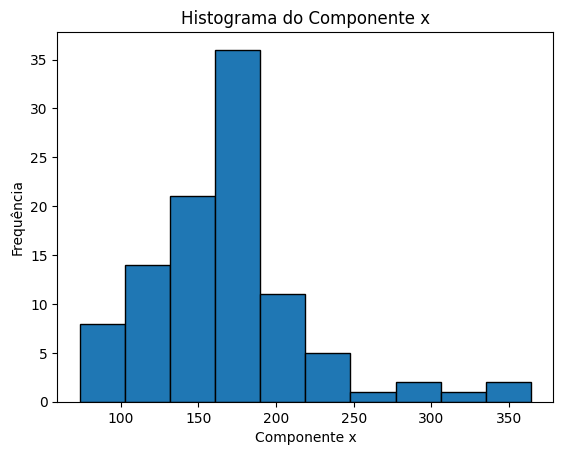

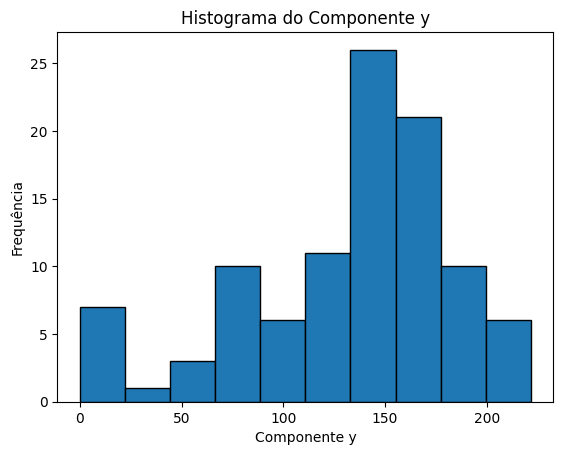

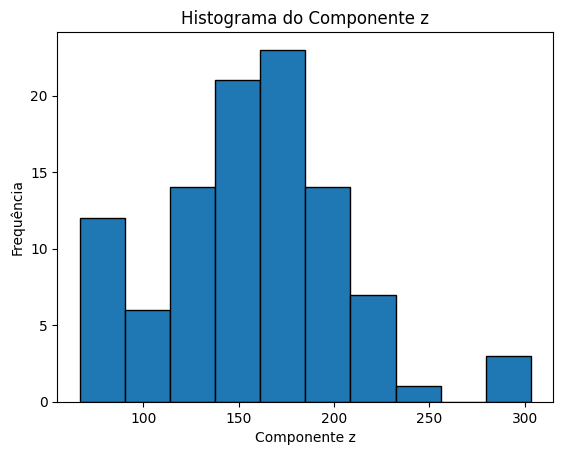

Terminou o histograma
Valores de média na iteração 1:
Portas: 1.0054405550707197
Estados: (1.0003396127469115+3.6716909774129206e-11j)
Distância: 4.893059500137573e-05
 
Tempo: 2
Começará a função principal
O rho gerado foi: [[1.0004529490295648, (-0.0016374913422536586-0.00023992257149340061j)], [(-0.0016374913422536586+0.00023992257149340061j), -0.00045294902956483085]]
Terminou a função principal
Veja o log: (Dos estados)
[(0.5188687610987504-6.454192296626903e-09j), (0.6035682727224457-1.1665709669957497e-08j), (0.7336857722749702+1.401959959938368e-08j), (0.8692073649687101-8.311959070745851e-09j), (0.9679842067203156-2.878578160098572e-09j), (0.9984655735737145+1.3450595268394885e-09j), (1.0010686989978734-3.437595538941237e-10j), (1.0013308365469973-2.8516128951800053e-11j), (1.001356099073309+2.4987544462131966e-11j), (1.0013545017318364+5.989496572819269e-11j), (1.0013449136910753-1.4354115593565745e-12j), (1.0013353482147949-2.917984816578434e-11j), (1.001324959810605-5.50571

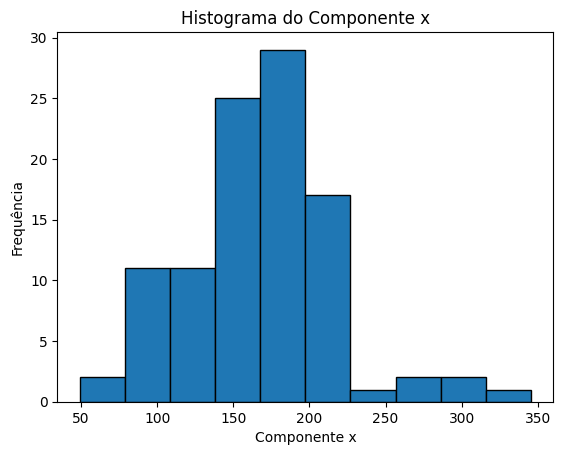

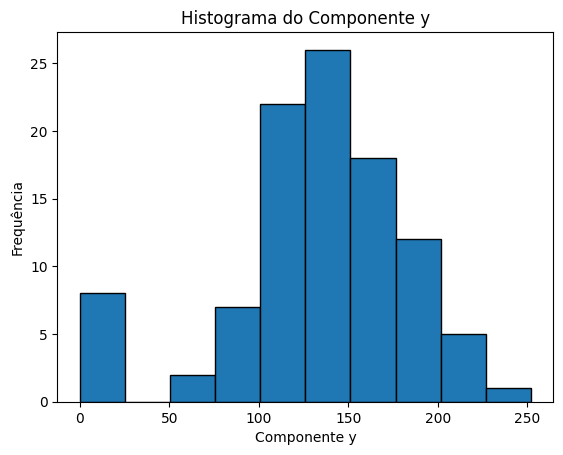

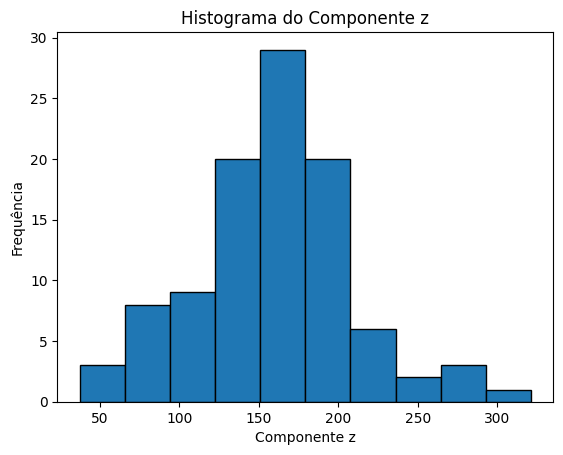

Terminou o histograma
Valores de média na iteração 2:
Portas: 1.006086318648602
Estados: (1.0003962809086113+1.0833781579035455e-11j)
Distância: 6.006009636455802e-05
 
Tempo: 3
Começará a função principal
O rho gerado foi: [[1.0026789850824693, (-0.0027062553511310004-0.0001828243403615145j)], [(-0.0027062553511310004+0.0001828243403615145j), -0.0026789850824693318]]
Terminou a função principal
Veja o log: (Dos estados)
[(0.5237063085687149+2.3986747316310365e-09j), (0.6162922950827924+3.000419354793432e-09j), (0.7491243292220692+4.778831374363386e-09j), (0.8830942983041307-7.20493439900051e-09j), (0.9756054998937626+5.471552787532933e-09j), (1.0002638530625707-2.3161157144026344e-10j), (1.0020930906573278+5.760801175981053e-10j), (1.002361642910949+2.4167943744094966e-10j), (1.002378786140626-2.5754126305804005e-12j), (1.002372736710529+9.398223398421594e-11j), (1.0023683744135239+2.976485024936171e-11j), (1.0023594290990938+6.129096332058566e-12j), (1.0023502896074679+1.291714470829

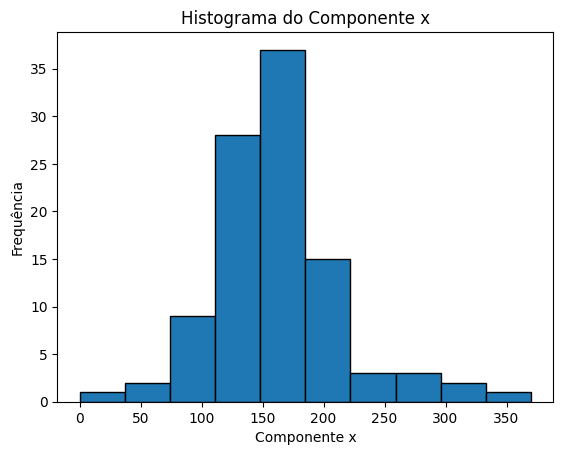

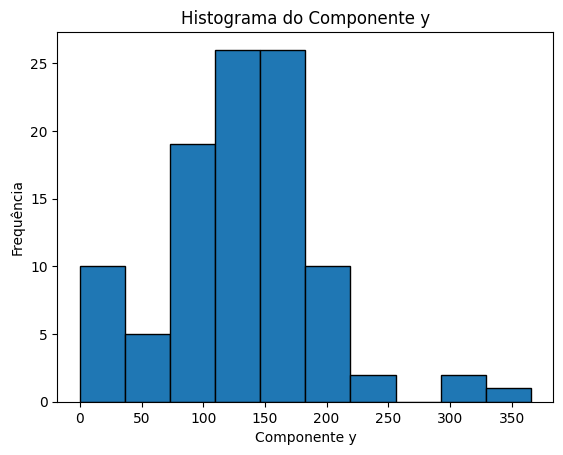

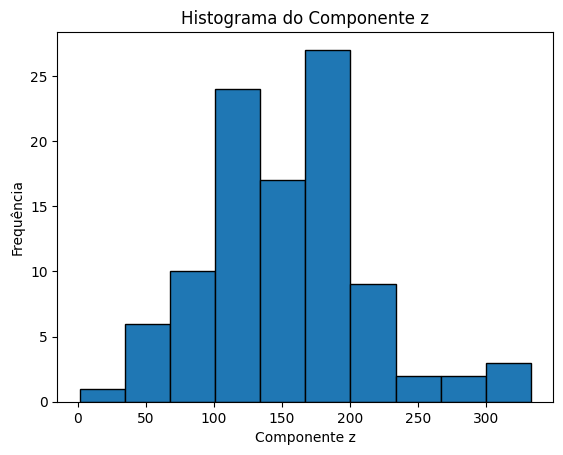

Terminou o histograma
Valores de média na iteração 3:
Portas: 1.0088707505510108
Estados: (1.0011571823047547+2.3653279959844348e-12j)
Distância: 0.00011253980784134325
 
Tempo: 4
Começará a função principal
O rho gerado foi: [[1.0001560558807001, (-0.0010872328645870504-9.09672360665024e-05j)], [(-0.0010872328645870504+9.09672360665024e-05j), -0.00015605588070022325]]
Terminou a função principal
Veja o log: (Dos estados)
[(0.523006794327347-3.5737474778401205e-09j), (0.6141697131995406-9.333295566527574e-09j), (0.7475200870138123-2.2050364296624455e-09j), (0.881629800925872-1.3030568803652795e-17j), (0.9747891735856561+8.37668935523945e-10j), (0.9968251337031051+9.30733479548317e-10j), (1.0006372306142548+3.7607433465830876e-11j), (1.001039285232306-1.674973256296202e-10j), (1.0010650565141048-6.366875554023013e-13j), (1.0010574488931177+1.7456359056179912e-11j), (1.0010474568159202-5.800831982586062e-12j), (1.0010372564524672+4.12604027836356e-11j), (1.0010271897048588-2.568767670322

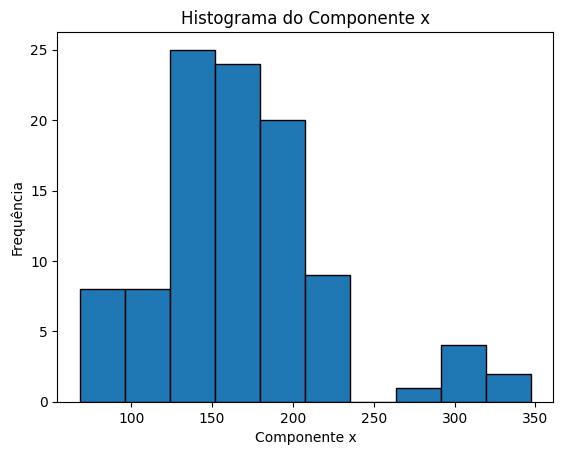

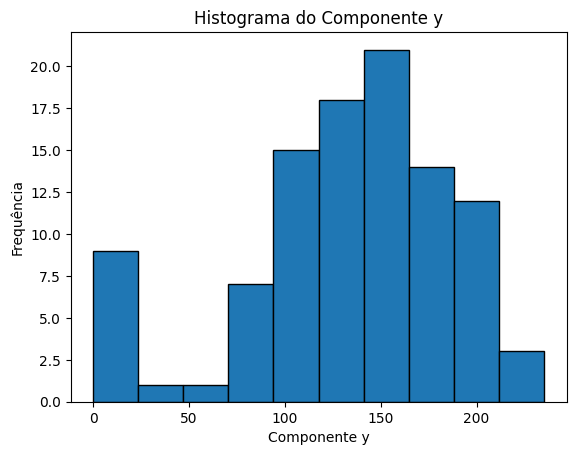

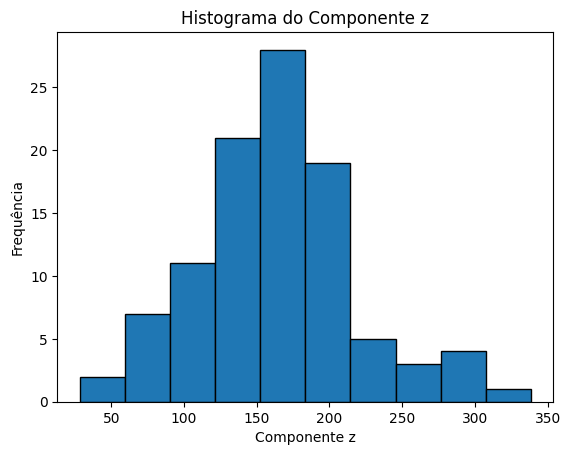

Terminou o histograma
Valores de média na iteração 4:
Portas: 1.0075325214995232
Estados: (1.0009069007113442+1.8396372867185693e-12j)
Distância: 9.085577447832241e-05
 
Tempo: 5
Começará a função principal
O rho gerado foi: [[1.0015621345895669, (-0.002384172915758189-0.0002842249174894779j)], [(-0.002384172915758189+0.0002842249174894779j), -0.001562134589566777]]
Terminou a função principal
Veja o log: (Dos estados)
[(0.5239481026948379-1.9011315754934146e-09j), (0.6140357777568501+1.3718400779879324e-09j), (0.7465820932708104+1.2284578693630203e-08j), (0.8804681585713026+1.3372119768241481e-08j), (0.9740030175852193-4.9024898425897145e-09j), (0.9994185318809861+2.5996610508268715e-10j), (1.0022830519080617+7.546705989828091e-10j), (1.0024636581304616+2.349025506483199e-10j), (1.0024768468531216+9.578236663622169e-13j), (1.002467721512453+5.8392660019387e-11j), (1.0024572803580043+6.181431342626987e-11j), (1.0024461729997776+1.0880051727781103e-11j), (1.0024360550256877+7.7182436173

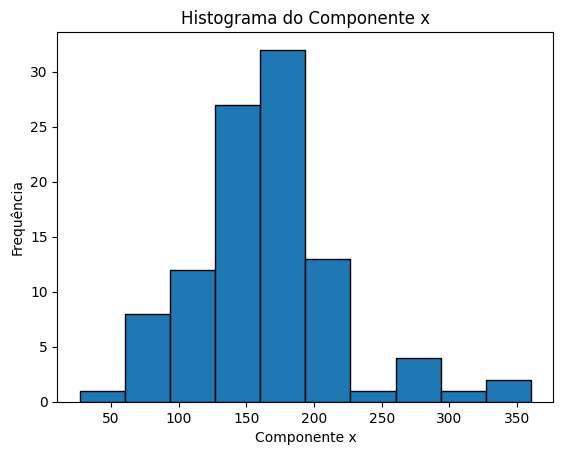

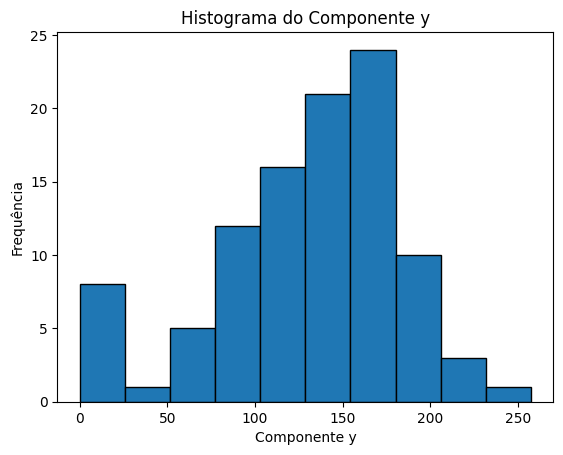

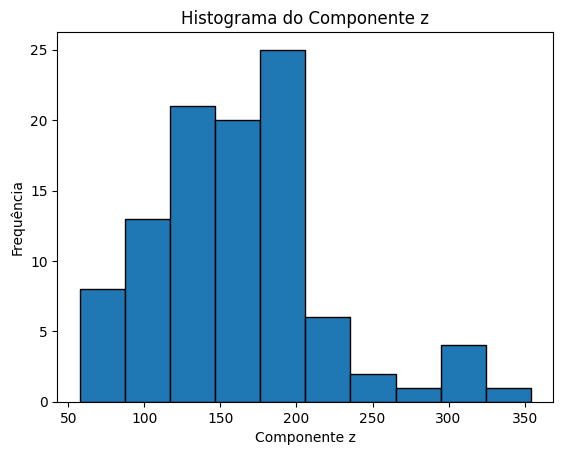

Terminou o histograma
Valores de média na iteração 5:
Portas: 1.008375842342673
Estados: (1.0010379474870872+2.0888210697886863e-11j)
Distância: 0.00010840680660217277
 
Tempo: 6
Começará a função principal
O rho gerado foi: [[1.0012921895066973, (-0.002031539648344449-0.00018666774723077092j)], [(-0.002031539648344449+0.00018666774723077092j), -0.0012921895066972944]]
Terminou a função principal
Veja o log: (Dos estados)
[(0.5265113486500064-1.8420559552944023e-09j), (0.6150311642954027+1.2959704717770975e-08j), (0.7463472423313628-7.847722549213337e-09j), (0.8795953648292965+5.5060962451243715e-09j), (0.9733582584963163+4.661349448763963e-10j), (0.9996674823958278+9.648570242693549e-10j), (1.0019427361884135-1.1652542918210611e-10j), (1.0021583458231016-1.6290855894684993e-10j), (1.0021958986834-6.514961214120416e-11j), (1.0021960232308147+3.126322355423685e-11j), (1.0021872374824792-1.1922385141302533e-11j), (1.0021762623878319+2.5314725466225048e-11j), (1.0021657113441118-1.3072448

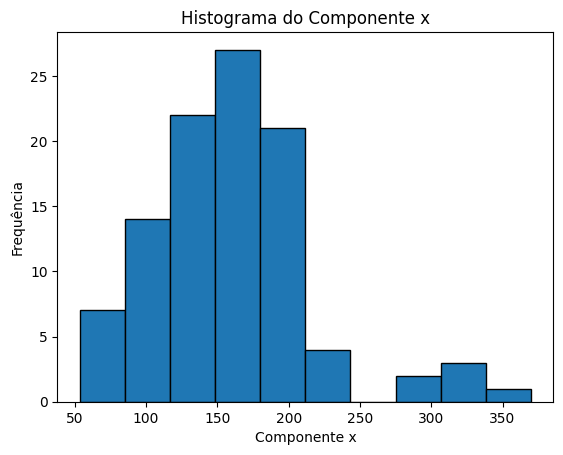

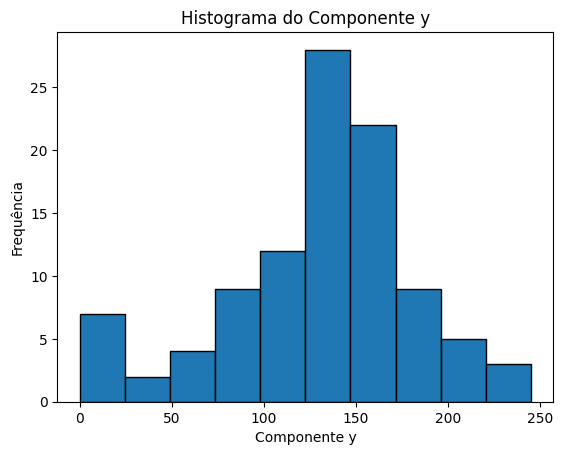

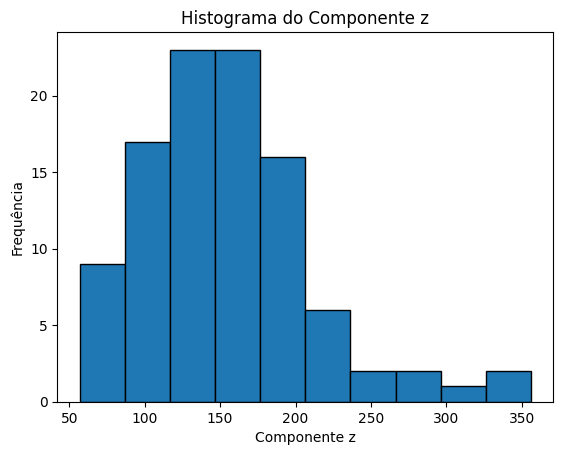

Terminou o histograma
Valores de média na iteração 6:
Portas: 1.0084558944172433
Estados: (1.0010803211785557+1.7489223726342497e-11j)
Distância: 0.00010880853140800261
 
Tempo: 7
Começará a função principal
O rho gerado foi: [[1.0005370812005978, (-0.001389237571568383-0.0005465613478901723j)], [(-0.001389237571568383+0.0005465613478901723j), -0.000537081200597811]]
Terminou a função principal
Veja o log: (Dos estados)
[(0.5163622040022181-6.623915475312371e-09j), (0.5912330911143385+1.5500278946328484e-10j), (0.7165145418469446+5.455525224881912e-10j), (0.8530111004988278-4.220729775441352e-09j), (0.9584814964845952-7.036308614811014e-09j), (0.9963445362857989+8.480602910022506e-10j), (1.0010788210235637-3.106347427737612e-10j), (1.001394139850236+4.4520563782999633e-13j), (1.001438922152218-9.807512462799226e-12j), (1.00143810467129-4.587028143605346e-11j), (1.0014291615119535-4.1208500405655705e-11j), (1.001419036025493-4.3686695375135654e-11j), (1.0014089818199903-2.21173474249830

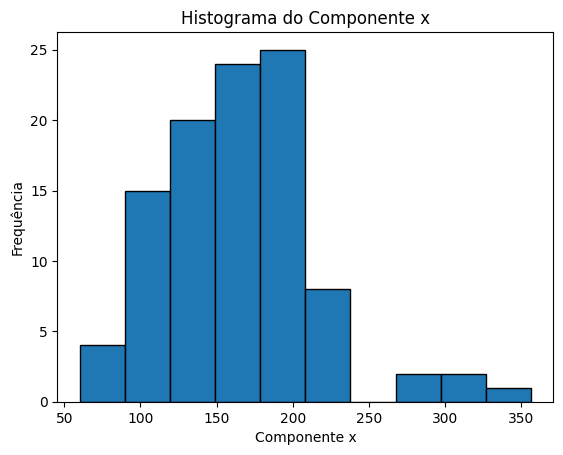

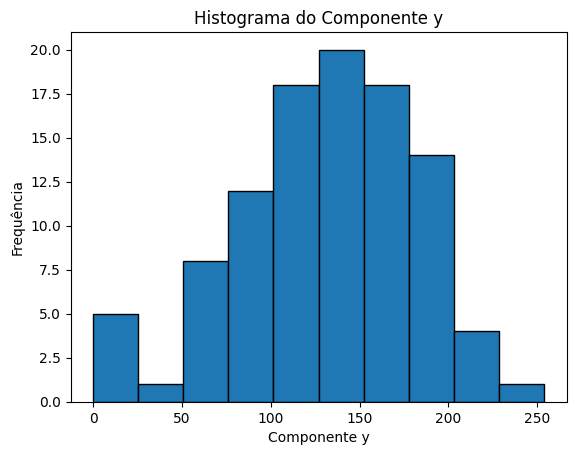

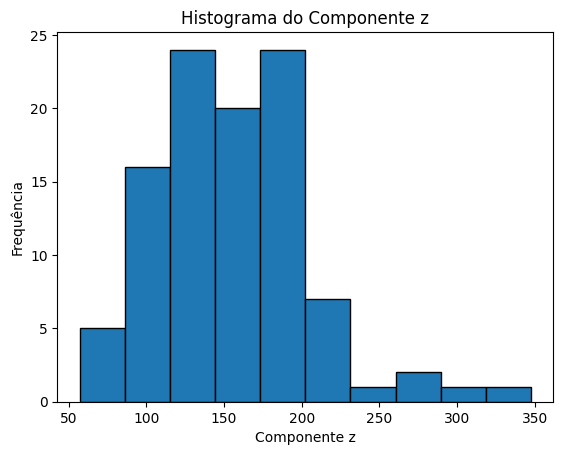

Terminou o histograma
Valores de média na iteração 7:
Portas: 1.0083474621148003
Estados: (1.0010027154780217+1.5660284483462828e-11j)
Distância: 0.00010462377753112322
 
Tempo: 8
Começará a função principal
O rho gerado foi: [[1.0025613406115021, (-0.003233455068944558-8.201016236994977e-05j)], [(-0.003233455068944558+8.201016236994977e-05j), -0.0025613406115022608]]
Terminou a função principal
Veja o log: (Dos estados)
[(0.5273168344381207+8.393002064799945e-10j), (0.6263204484867446+5.242183109752153e-09j), (0.7552791450631327-6.008904357784618e-09j), (0.8885233707883866+2.463435233399854e-09j), (0.9782590770152726+3.3498267141910047e-09j), (1.0016974748383825+7.137955421489057e-10j), (1.0032858836547902-3.498359912990232e-10j), (1.0034298707533154-1.3879603419557228e-10j), (1.003449938831294-1.9949570312392276e-10j), (1.003454731715629-1.1333454311483163e-10j), (1.0034485220558216+1.462185279440162e-11j), (1.0034396834861763-1.4449615665922515e-11j), (1.003430243486777-1.6333458389

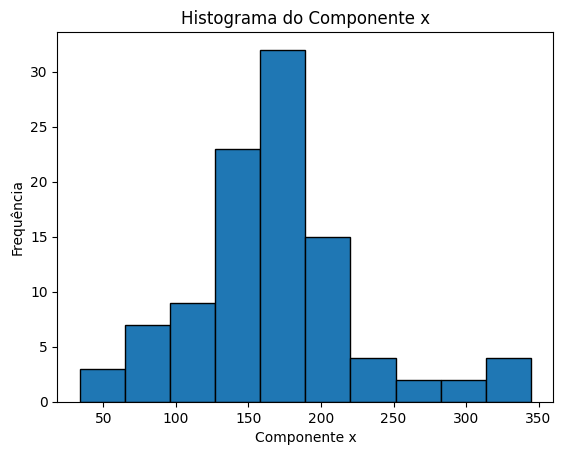

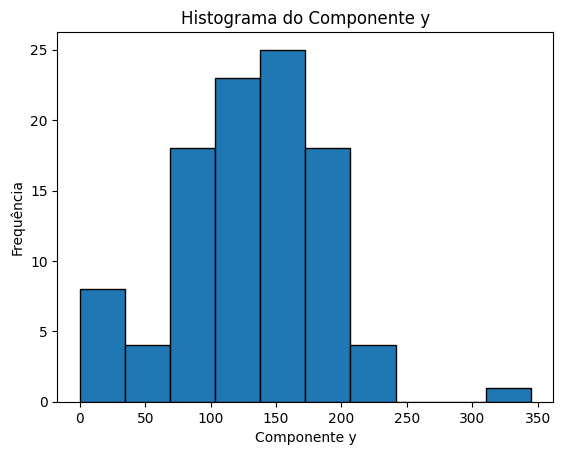

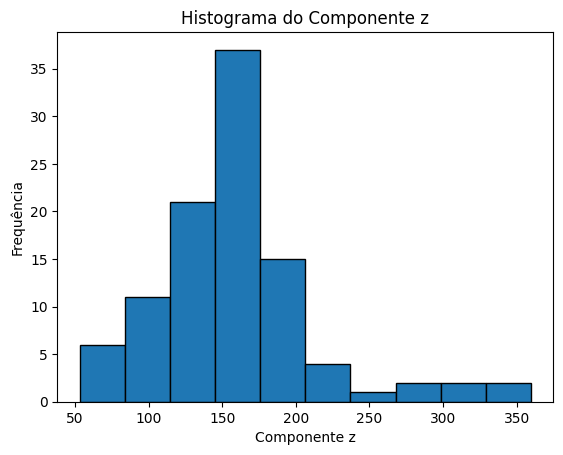

Terminou o histograma
Valores de média na iteração 8:
Portas: 1.0092453429777053
Estados: (1.0011975436280258+1.263930860208864e-11j)
Distância: 0.0001298747003886688
 
Tempo: 9
Começará a função principal
O rho gerado foi: [[1.0006805824979579, (-0.0021025732263629782-0.00044173836323034506j)], [(-0.0021025732263629782+0.00044173836323034506j), -0.0006805824979579933]]
Terminou a função principal
Veja o log: (Dos estados)
[(0.5224598306120187+7.865084309906206e-10j), (0.6078901307660073-9.102371704042479e-10j), (0.7381732783074635-9.374606945071624e-09j), (0.8727528798386941-5.92284819616622e-09j), (0.9695353140458799+4.418795462986298e-09j), (0.9985798870925509-5.769243317423119e-10j), (1.0011604809554802+1.5464747227938813e-10j), (1.0015666838474087+5.502097779493961e-11j), (1.0015900245494103-8.071524383499748e-11j), (1.0015833091016333-5.224942758212682e-11j), (1.0015736136392475+7.105727321677157e-11j), (1.001563345249647+9.244071687460932e-12j), (1.001552805389691-1.748794192164

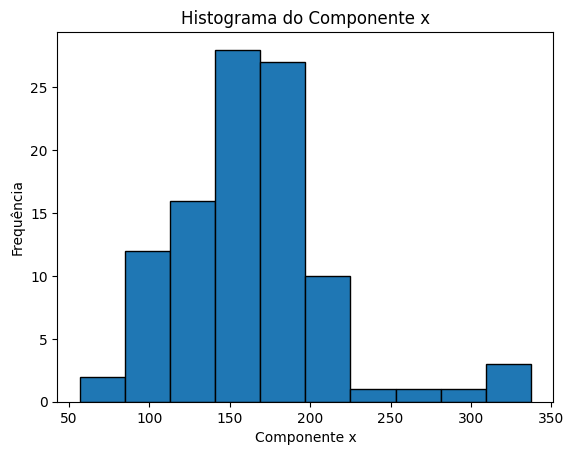

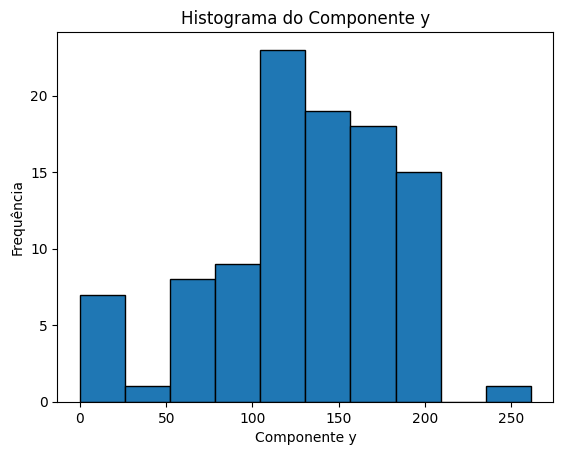

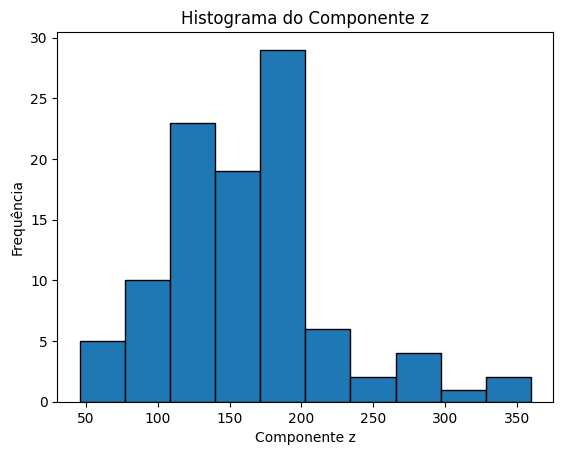

Terminou o histograma
Valores de média na iteração 9:
Portas: 1.0093101088462502
Estados: (1.0011401035044825+1.1182826269157556e-11j)
Distância: 0.0001306010907125377
 
Tempo: 10
Começará a função principal
O rho gerado foi: [[1.0018114348463534, (-0.0030572382781078405-0.0001954527076090931j)], [(-0.0030572382781078405+0.0001954527076090931j), -0.001811434846353377]]
Terminou a função principal
Veja o log: (Dos estados)
[(0.5256377805035056-1.1307224182877242e-08j), (0.6223917807193611-4.25075659444678e-09j), (0.7493780132423944+1.3846959121934836e-08j), (0.8841492063137312-9.061635040727925e-09j), (0.9764608783733897+3.5969346537220726e-09j), (1.0003961663677192+6.517126123653259e-10j), (1.0024341534048187+6.424201609304105e-10j), (1.002650902597762+5.436263288268789e-10j), (1.0026914961775832+5.0921472824659534e-11j), (1.0027022598890838+2.3040513339314996e-10j), (1.0026982073264654+9.482202441679263e-12j), (1.002689951553328-1.1662833189647293e-10j), (1.0026808558169766-1.92250217

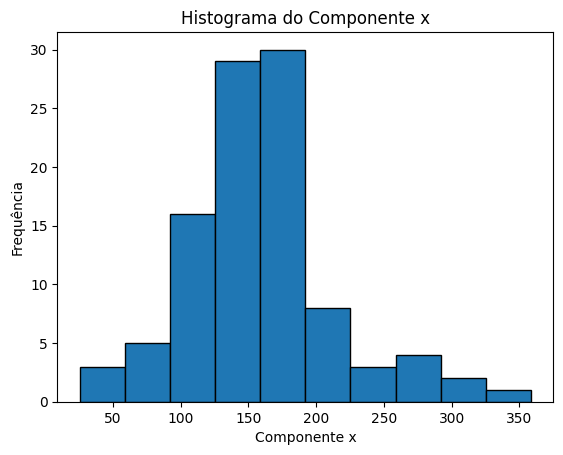

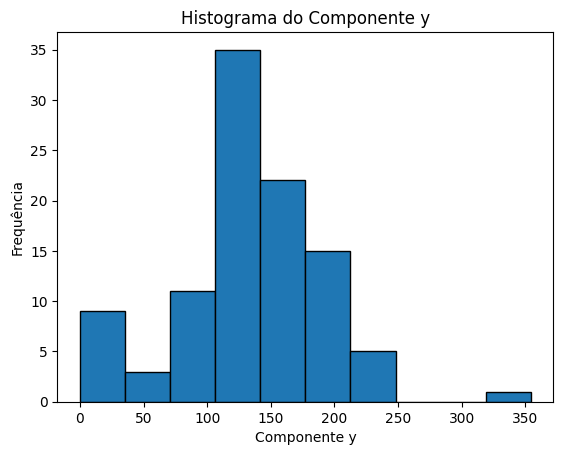

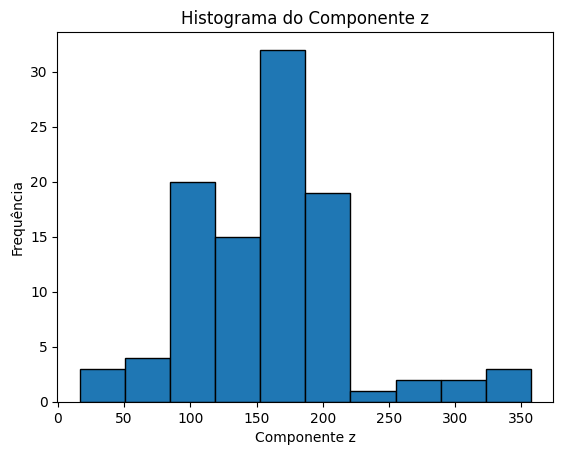

Terminou o histograma
Valores de média na iteração 10:
Portas: 1.0096774819360073
Estados: (1.0012072366387053+1.3935532372667284e-11j)
Distância: 0.00013968660766596928
 


In [21]:
portas = []
estados = []
distancia = []

for i in range(1, 11):

    print(f"Tempo: {i}")

    print(f"Começará a função principal")
    fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, a = main()
    print(f"Terminou a função principal")
    print(f"Veja o log: (Dos estados)")
    print(fid_vector)
    print(f"Veja o log: (Das portas)")
    print(fid_autores)

    portas.append(fid_autores[-1])
    estados.append(fid_vector[-1])
    distancia.append(distance_vector[-1])

    print(f"Começou o histograma")
    histograma(0, a)
    histograma(1, a)
    histograma(2, a)
    print(f"Terminou o histograma")
    
    print(f"Valores de média na iteração {i}:")
    print(f"Portas: {sum(portas)/i}")
    print(f"Estados: {sum(estados)/i}")
    print(f"Distância: {sum(distancia)/i}")
    print(" ")